# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 16 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/50, Loss: 0.8771
Epoch 1/200, Iteration 2/50, Loss: 1.3497
Epoch 1/200, Iteration 3/50, Loss: 1.7439
Epoch 1/200, Iteration 4/50, Loss: 1.4451
Epoch 1/200, Iteration 5/50, Loss: 0.9142
Epoch 1/200, Iteration 6/50, Loss: 0.5437
Epoch 1/200, Iteration 7/50, Loss: 0.5843
Epoch 1/200, Iteration 8/50, Loss: 0.5402
Epoch 1/200, Iteration 9/50, Loss: 0.9690
Epoch 1/200, Iteration 10/50, Loss: 0.6292
Epoch 1/200, Iteration 11/50, Loss: 0.6372
Epoch 1/200, Iteration 12/50, Loss: 0.4460
Epoch 1/200, Iteration 13/50, Loss: 0.7343
Epoch 1/200, Iteration 14/50, Loss: 0.4211
Epoch 1/200, Iteration 15/50, Loss: 0.4787
Epoch 1/200, Iteration 16/50, Loss: 0.5125
Epoch 1/200, Iteration 17/50, Loss: 0.4800
Epoch 1/200, Iteration 18/50, Loss: 0.4407
Epoch 1/200, Iteration 19/50, Loss: 0.3376
Epoch 1/200, Iteration 20/50, Loss: 0.4557
Epoch 1/200, Iteration 21/50, Loss: 0.4253
Epoch 1/200, Iteration 22/50, Loss: 0.5083
Epoch 1/200, Iteration 23/50, Loss: 0.3134
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 70.88%, Avg loss: 0.218137, MRE: 0.219769, MAE: 0.028843 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.223959, MRE: 0.187758, MAE: 0.029697 

Epoch 5/200, Iteration 1/50, Loss: 0.2092
Epoch 5/200, Iteration 2/50, Loss: 0.1677
Epoch 5/200, Iteration 3/50, Loss: 0.1437
Epoch 5/200, Iteration 4/50, Loss: 0.2467
Epoch 5/200, Iteration 5/50, Loss: 0.1847
Epoch 5/200, Iteration 6/50, Loss: 0.2212
Epoch 5/200, Iteration 7/50, Loss: 0.1844
Epoch 5/200, Iteration 8/50, Loss: 0.2515
Epoch 5/200, Iteration 9/50, Loss: 0.1870
Epoch 5/200, Iteration 10/50, Loss: 0.1883
Epoch 5/200, Iteration 11/50, Loss: 0.2619
Epoch 5/200, Iteration 12/50, Loss: 0.2344
Epoch 5/200, Iteration 13/50, Loss: 0.2065
Epoch 5/200, Iteration 14/50, Loss: 0.1402
Epoch 5/200, Iteration 15/50, Loss: 0.1372
Epoch 5/200, Iteration 16/50, Loss: 0.2022
Epoch 5/200, Iteration 17/50, Loss: 0.1766
Epoch 5/200, Iteration 18/50, Loss: 0.1542
Epoch 5/200, Iteration 19/50, Loss: 0.2049
Epoch 5/200, Iteration 20/

Epoch 8/200, Iteration 31/50, Loss: 0.2757
Epoch 8/200, Iteration 32/50, Loss: 0.2256
Epoch 8/200, Iteration 33/50, Loss: 0.1853
Epoch 8/200, Iteration 34/50, Loss: 0.2215
Epoch 8/200, Iteration 35/50, Loss: 0.2411
Epoch 8/200, Iteration 36/50, Loss: 0.2171
Epoch 8/200, Iteration 37/50, Loss: 0.1699
Epoch 8/200, Iteration 38/50, Loss: 0.1822
Epoch 8/200, Iteration 39/50, Loss: 0.2593
Epoch 8/200, Iteration 40/50, Loss: 0.1520
Epoch 8/200, Iteration 41/50, Loss: 0.1692
Epoch 8/200, Iteration 42/50, Loss: 0.2037
Epoch 8/200, Iteration 43/50, Loss: 0.1754
Epoch 8/200, Iteration 44/50, Loss: 0.2226
Epoch 8/200, Iteration 45/50, Loss: 0.1841
Epoch 8/200, Iteration 46/50, Loss: 0.2016
Epoch 8/200, Iteration 47/50, Loss: 0.1802
Epoch 8/200, Iteration 48/50, Loss: 0.2747
Epoch 8/200, Iteration 49/50, Loss: 0.3238
Epoch 8/200, Iteration 50/50, Loss: 0.2791
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.168721, MRE: 0.114844, MAE: 0.021997 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.155423, MRE: 0

Epoch 12/200, Iteration 32/50, Loss: 0.1616
Epoch 12/200, Iteration 33/50, Loss: 0.1565
Epoch 12/200, Iteration 34/50, Loss: 0.1677
Epoch 12/200, Iteration 35/50, Loss: 0.2198
Epoch 12/200, Iteration 36/50, Loss: 0.1359
Epoch 12/200, Iteration 37/50, Loss: 0.1560
Epoch 12/200, Iteration 38/50, Loss: 0.1408
Epoch 12/200, Iteration 39/50, Loss: 0.1912
Epoch 12/200, Iteration 40/50, Loss: 0.1759
Epoch 12/200, Iteration 41/50, Loss: 0.2112
Epoch 12/200, Iteration 42/50, Loss: 0.1811
Epoch 12/200, Iteration 43/50, Loss: 0.1056
Epoch 12/200, Iteration 44/50, Loss: 0.2133
Epoch 12/200, Iteration 45/50, Loss: 0.1489
Epoch 12/200, Iteration 46/50, Loss: 0.3088
Epoch 12/200, Iteration 47/50, Loss: 0.2504
Epoch 12/200, Iteration 48/50, Loss: 0.2691
Epoch 12/200, Iteration 49/50, Loss: 0.2400
Epoch 12/200, Iteration 50/50, Loss: 0.2358
Train Error: 
 Accuracy: 83.88%, Avg loss: 0.241592, MRE: 0.208914, MAE: 0.029346 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.224271, MRE: 0.176973, MAE: 0.027190 

Epoch 16/200, Iteration 34/50, Loss: 0.3032
Epoch 16/200, Iteration 35/50, Loss: 0.2622
Epoch 16/200, Iteration 36/50, Loss: 0.1801
Epoch 16/200, Iteration 37/50, Loss: 0.2181
Epoch 16/200, Iteration 38/50, Loss: 0.2631
Epoch 16/200, Iteration 39/50, Loss: 0.1524
Epoch 16/200, Iteration 40/50, Loss: 0.2844
Epoch 16/200, Iteration 41/50, Loss: 0.1657
Epoch 16/200, Iteration 42/50, Loss: 0.3187
Epoch 16/200, Iteration 43/50, Loss: 0.2772
Epoch 16/200, Iteration 44/50, Loss: 0.1746
Epoch 16/200, Iteration 45/50, Loss: 0.2500
Epoch 16/200, Iteration 46/50, Loss: 0.1957
Epoch 16/200, Iteration 47/50, Loss: 0.2177
Epoch 16/200, Iteration 48/50, Loss: 0.3086
Epoch 16/200, Iteration 49/50, Loss: 0.2706
Epoch 16/200, Iteration 50/50, Loss: 0.1880
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.187029, MRE: 0.144591, MAE: 0.024238 

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.188537, MRE: 0.127293, MAE: 0.024583 

Epoch 17/200, Iteration 1/50, Loss: 0.2151
Epoch 17/200, Iteration 2/50, Loss: 0.2164


Epoch 20/200, Iteration 35/50, Loss: 0.1325
Epoch 20/200, Iteration 36/50, Loss: 0.1016
Epoch 20/200, Iteration 37/50, Loss: 0.0967
Epoch 20/200, Iteration 38/50, Loss: 0.0976
Epoch 20/200, Iteration 39/50, Loss: 0.1237
Epoch 20/200, Iteration 40/50, Loss: 0.1124
Epoch 20/200, Iteration 41/50, Loss: 0.0966
Epoch 20/200, Iteration 42/50, Loss: 0.1220
Epoch 20/200, Iteration 43/50, Loss: 0.1156
Epoch 20/200, Iteration 44/50, Loss: 0.0960
Epoch 20/200, Iteration 45/50, Loss: 0.1018
Epoch 20/200, Iteration 46/50, Loss: 0.1228
Epoch 20/200, Iteration 47/50, Loss: 0.1158
Epoch 20/200, Iteration 48/50, Loss: 0.1103
Epoch 20/200, Iteration 49/50, Loss: 0.1038
Epoch 20/200, Iteration 50/50, Loss: 0.0959
Train Error: 
 Accuracy: 72.38%, Avg loss: 0.096153, MRE: 0.069459, MAE: 0.012481 

Test Error: 
 Accuracy: 71.0%, Avg loss: 0.107380, MRE: 0.076222, MAE: 0.013846 

Epoch 21/200, Iteration 1/50, Loss: 0.0896
Epoch 21/200, Iteration 2/50, Loss: 0.0810
Epoch 21/200, Iteration 3/50, Loss: 0.0850
E

Epoch 24/200, Iteration 35/50, Loss: 0.0448
Epoch 24/200, Iteration 36/50, Loss: 0.0481
Epoch 24/200, Iteration 37/50, Loss: 0.0598
Epoch 24/200, Iteration 38/50, Loss: 0.0343
Epoch 24/200, Iteration 39/50, Loss: 0.0494
Epoch 24/200, Iteration 40/50, Loss: 0.0624
Epoch 24/200, Iteration 41/50, Loss: 0.0579
Epoch 24/200, Iteration 42/50, Loss: 0.0473
Epoch 24/200, Iteration 43/50, Loss: 0.0687
Epoch 24/200, Iteration 44/50, Loss: 0.0614
Epoch 24/200, Iteration 45/50, Loss: 0.0527
Epoch 24/200, Iteration 46/50, Loss: 0.0514
Epoch 24/200, Iteration 47/50, Loss: 0.0488
Epoch 24/200, Iteration 48/50, Loss: 0.0759
Epoch 24/200, Iteration 49/50, Loss: 0.0559
Epoch 24/200, Iteration 50/50, Loss: 0.0436
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.048052, MRE: 0.036056, MAE: 0.006367 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.061062, MRE: 0.039658, MAE: 0.007598 

Epoch 25/200, Iteration 1/50, Loss: 0.0556
Epoch 25/200, Iteration 2/50, Loss: 0.0496
Epoch 25/200, Iteration 3/50, Loss: 0.0494
E

Epoch 28/200, Iteration 35/50, Loss: 0.0271
Epoch 28/200, Iteration 36/50, Loss: 0.0414
Epoch 28/200, Iteration 37/50, Loss: 0.0398
Epoch 28/200, Iteration 38/50, Loss: 0.0504
Epoch 28/200, Iteration 39/50, Loss: 0.0511
Epoch 28/200, Iteration 40/50, Loss: 0.0408
Epoch 28/200, Iteration 41/50, Loss: 0.0330
Epoch 28/200, Iteration 42/50, Loss: 0.0418
Epoch 28/200, Iteration 43/50, Loss: 0.0493
Epoch 28/200, Iteration 44/50, Loss: 0.0391
Epoch 28/200, Iteration 45/50, Loss: 0.0469
Epoch 28/200, Iteration 46/50, Loss: 0.0516
Epoch 28/200, Iteration 47/50, Loss: 0.0410
Epoch 28/200, Iteration 48/50, Loss: 0.0485
Epoch 28/200, Iteration 49/50, Loss: 0.0516
Epoch 28/200, Iteration 50/50, Loss: 0.0513
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.039530, MRE: 0.028974, MAE: 0.005326 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.054693, MRE: 0.036609, MAE: 0.007135 

Epoch 29/200, Iteration 1/50, Loss: 0.0400
Epoch 29/200, Iteration 2/50, Loss: 0.0429
Epoch 29/200, Iteration 3/50, Loss: 0.0377
E

Epoch 32/200, Iteration 31/50, Loss: 0.0587
Epoch 32/200, Iteration 32/50, Loss: 0.0469
Epoch 32/200, Iteration 33/50, Loss: 0.0320
Epoch 32/200, Iteration 34/50, Loss: 0.0407
Epoch 32/200, Iteration 35/50, Loss: 0.0649
Epoch 32/200, Iteration 36/50, Loss: 0.0470
Epoch 32/200, Iteration 37/50, Loss: 0.0486
Epoch 32/200, Iteration 38/50, Loss: 0.0437
Epoch 32/200, Iteration 39/50, Loss: 0.0289
Epoch 32/200, Iteration 40/50, Loss: 0.0629
Epoch 32/200, Iteration 41/50, Loss: 0.0508
Epoch 32/200, Iteration 42/50, Loss: 0.0380
Epoch 32/200, Iteration 43/50, Loss: 0.0336
Epoch 32/200, Iteration 44/50, Loss: 0.0411
Epoch 32/200, Iteration 45/50, Loss: 0.0590
Epoch 32/200, Iteration 46/50, Loss: 0.0417
Epoch 32/200, Iteration 47/50, Loss: 0.0399
Epoch 32/200, Iteration 48/50, Loss: 0.0482
Epoch 32/200, Iteration 49/50, Loss: 0.0582
Epoch 32/200, Iteration 50/50, Loss: 0.0388
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.035872, MRE: 0.025731, MAE: 0.004664 

Test Error: 
 Accuracy: 93.0%, Avg l

Epoch 36/200, Iteration 29/50, Loss: 0.0402
Epoch 36/200, Iteration 30/50, Loss: 0.0407
Epoch 36/200, Iteration 31/50, Loss: 0.0424
Epoch 36/200, Iteration 32/50, Loss: 0.0501
Epoch 36/200, Iteration 33/50, Loss: 0.0460
Epoch 36/200, Iteration 34/50, Loss: 0.0426
Epoch 36/200, Iteration 35/50, Loss: 0.0348
Epoch 36/200, Iteration 36/50, Loss: 0.0316
Epoch 36/200, Iteration 37/50, Loss: 0.0355
Epoch 36/200, Iteration 38/50, Loss: 0.0454
Epoch 36/200, Iteration 39/50, Loss: 0.0352
Epoch 36/200, Iteration 40/50, Loss: 0.0361
Epoch 36/200, Iteration 41/50, Loss: 0.0326
Epoch 36/200, Iteration 42/50, Loss: 0.0354
Epoch 36/200, Iteration 43/50, Loss: 0.0361
Epoch 36/200, Iteration 44/50, Loss: 0.0311
Epoch 36/200, Iteration 45/50, Loss: 0.0378
Epoch 36/200, Iteration 46/50, Loss: 0.0357
Epoch 36/200, Iteration 47/50, Loss: 0.0339
Epoch 36/200, Iteration 48/50, Loss: 0.0347
Epoch 36/200, Iteration 49/50, Loss: 0.0348
Epoch 36/200, Iteration 50/50, Loss: 0.0411
Train Error: 
 Accuracy: 98.38%,

Epoch 40/200, Iteration 22/50, Loss: 0.0334
Epoch 40/200, Iteration 23/50, Loss: 0.0306
Epoch 40/200, Iteration 24/50, Loss: 0.0314
Epoch 40/200, Iteration 25/50, Loss: 0.0340
Epoch 40/200, Iteration 26/50, Loss: 0.0311
Epoch 40/200, Iteration 27/50, Loss: 0.0402
Epoch 40/200, Iteration 28/50, Loss: 0.0274
Epoch 40/200, Iteration 29/50, Loss: 0.0348
Epoch 40/200, Iteration 30/50, Loss: 0.0392
Epoch 40/200, Iteration 31/50, Loss: 0.0367
Epoch 40/200, Iteration 32/50, Loss: 0.0270
Epoch 40/200, Iteration 33/50, Loss: 0.0408
Epoch 40/200, Iteration 34/50, Loss: 0.0473
Epoch 40/200, Iteration 35/50, Loss: 0.0305
Epoch 40/200, Iteration 36/50, Loss: 0.0302
Epoch 40/200, Iteration 37/50, Loss: 0.0492
Epoch 40/200, Iteration 38/50, Loss: 0.0297
Epoch 40/200, Iteration 39/50, Loss: 0.0360
Epoch 40/200, Iteration 40/50, Loss: 0.0277
Epoch 40/200, Iteration 41/50, Loss: 0.0429
Epoch 40/200, Iteration 42/50, Loss: 0.0320
Epoch 40/200, Iteration 43/50, Loss: 0.0229
Epoch 40/200, Iteration 44/50, L

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.037947, MRE: 0.027828, MAE: 0.004671 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.048842, MRE: 0.031307, MAE: 0.006055 

Epoch 44/200, Iteration 1/50, Loss: 0.0374
Epoch 44/200, Iteration 2/50, Loss: 0.0457
Epoch 44/200, Iteration 3/50, Loss: 0.0333
Epoch 44/200, Iteration 4/50, Loss: 0.0423
Epoch 44/200, Iteration 5/50, Loss: 0.0487
Epoch 44/200, Iteration 6/50, Loss: 0.0501
Epoch 44/200, Iteration 7/50, Loss: 0.0462
Epoch 44/200, Iteration 8/50, Loss: 0.0439
Epoch 44/200, Iteration 9/50, Loss: 0.0548
Epoch 44/200, Iteration 10/50, Loss: 0.0460
Epoch 44/200, Iteration 11/50, Loss: 0.0358
Epoch 44/200, Iteration 12/50, Loss: 0.0396
Epoch 44/200, Iteration 13/50, Loss: 0.0367
Epoch 44/200, Iteration 14/50, Loss: 0.0549
Epoch 44/200, Iteration 15/50, Loss: 0.0415
Epoch 44/200, Iteration 16/50, Loss: 0.0428
Epoch 44/200, Iteration 17/50, Loss: 0.0426
Epoch 44/200, Iteration 18/50, Loss: 0.0324
Epoch 44/200, Iteration 19/50, Loss: 0.0319
Epoch 44

Epoch 47/200, Iteration 32/50, Loss: 0.0263
Epoch 47/200, Iteration 33/50, Loss: 0.0437
Epoch 47/200, Iteration 34/50, Loss: 0.0332
Epoch 47/200, Iteration 35/50, Loss: 0.0337
Epoch 47/200, Iteration 36/50, Loss: 0.0413
Epoch 47/200, Iteration 37/50, Loss: 0.0352
Epoch 47/200, Iteration 38/50, Loss: 0.0457
Epoch 47/200, Iteration 39/50, Loss: 0.0349
Epoch 47/200, Iteration 40/50, Loss: 0.0318
Epoch 47/200, Iteration 41/50, Loss: 0.0345
Epoch 47/200, Iteration 42/50, Loss: 0.0347
Epoch 47/200, Iteration 43/50, Loss: 0.0294
Epoch 47/200, Iteration 44/50, Loss: 0.0372
Epoch 47/200, Iteration 45/50, Loss: 0.0345
Epoch 47/200, Iteration 46/50, Loss: 0.0243
Epoch 47/200, Iteration 47/50, Loss: 0.0372
Epoch 47/200, Iteration 48/50, Loss: 0.0452
Epoch 47/200, Iteration 49/50, Loss: 0.0545
Epoch 47/200, Iteration 50/50, Loss: 0.0336
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.050002, MRE: 0.034661, MAE: 0.006131 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.061133, MRE: 0.036156, MAE: 0.007312

Epoch 51/200, Iteration 29/50, Loss: 0.0180
Epoch 51/200, Iteration 30/50, Loss: 0.0165
Epoch 51/200, Iteration 31/50, Loss: 0.0191
Epoch 51/200, Iteration 32/50, Loss: 0.0137
Epoch 51/200, Iteration 33/50, Loss: 0.0183
Epoch 51/200, Iteration 34/50, Loss: 0.0194
Epoch 51/200, Iteration 35/50, Loss: 0.0213
Epoch 51/200, Iteration 36/50, Loss: 0.0195
Epoch 51/200, Iteration 37/50, Loss: 0.0158
Epoch 51/200, Iteration 38/50, Loss: 0.0199
Epoch 51/200, Iteration 39/50, Loss: 0.0141
Epoch 51/200, Iteration 40/50, Loss: 0.0177
Epoch 51/200, Iteration 41/50, Loss: 0.0191
Epoch 51/200, Iteration 42/50, Loss: 0.0181
Epoch 51/200, Iteration 43/50, Loss: 0.0185
Epoch 51/200, Iteration 44/50, Loss: 0.0195
Epoch 51/200, Iteration 45/50, Loss: 0.0169
Epoch 51/200, Iteration 46/50, Loss: 0.0165
Epoch 51/200, Iteration 47/50, Loss: 0.0193
Epoch 51/200, Iteration 48/50, Loss: 0.0169
Epoch 51/200, Iteration 49/50, Loss: 0.0226
Epoch 51/200, Iteration 50/50, Loss: 0.0141
Train Error: 
 Accuracy: 100.0%,

Epoch 55/200, Iteration 26/50, Loss: 0.0143
Epoch 55/200, Iteration 27/50, Loss: 0.0164
Epoch 55/200, Iteration 28/50, Loss: 0.0165
Epoch 55/200, Iteration 29/50, Loss: 0.0185
Epoch 55/200, Iteration 30/50, Loss: 0.0117
Epoch 55/200, Iteration 31/50, Loss: 0.0161
Epoch 55/200, Iteration 32/50, Loss: 0.0193
Epoch 55/200, Iteration 33/50, Loss: 0.0124
Epoch 55/200, Iteration 34/50, Loss: 0.0137
Epoch 55/200, Iteration 35/50, Loss: 0.0133
Epoch 55/200, Iteration 36/50, Loss: 0.0167
Epoch 55/200, Iteration 37/50, Loss: 0.0171
Epoch 55/200, Iteration 38/50, Loss: 0.0153
Epoch 55/200, Iteration 39/50, Loss: 0.0186
Epoch 55/200, Iteration 40/50, Loss: 0.0177
Epoch 55/200, Iteration 41/50, Loss: 0.0123
Epoch 55/200, Iteration 42/50, Loss: 0.0187
Epoch 55/200, Iteration 43/50, Loss: 0.0135
Epoch 55/200, Iteration 44/50, Loss: 0.0178
Epoch 55/200, Iteration 45/50, Loss: 0.0169
Epoch 55/200, Iteration 46/50, Loss: 0.0233
Epoch 55/200, Iteration 47/50, Loss: 0.0146
Epoch 55/200, Iteration 48/50, L

Epoch 59/200, Iteration 28/50, Loss: 0.0130
Epoch 59/200, Iteration 29/50, Loss: 0.0147
Epoch 59/200, Iteration 30/50, Loss: 0.0127
Epoch 59/200, Iteration 31/50, Loss: 0.0249
Epoch 59/200, Iteration 32/50, Loss: 0.0159
Epoch 59/200, Iteration 33/50, Loss: 0.0182
Epoch 59/200, Iteration 34/50, Loss: 0.0179
Epoch 59/200, Iteration 35/50, Loss: 0.0154
Epoch 59/200, Iteration 36/50, Loss: 0.0124
Epoch 59/200, Iteration 37/50, Loss: 0.0138
Epoch 59/200, Iteration 38/50, Loss: 0.0104
Epoch 59/200, Iteration 39/50, Loss: 0.0099
Epoch 59/200, Iteration 40/50, Loss: 0.0172
Epoch 59/200, Iteration 41/50, Loss: 0.0136
Epoch 59/200, Iteration 42/50, Loss: 0.0205
Epoch 59/200, Iteration 43/50, Loss: 0.0175
Epoch 59/200, Iteration 44/50, Loss: 0.0141
Epoch 59/200, Iteration 45/50, Loss: 0.0184
Epoch 59/200, Iteration 46/50, Loss: 0.0181
Epoch 59/200, Iteration 47/50, Loss: 0.0143
Epoch 59/200, Iteration 48/50, Loss: 0.0141
Epoch 59/200, Iteration 49/50, Loss: 0.0154
Epoch 59/200, Iteration 50/50, L

Epoch 63/200, Iteration 23/50, Loss: 0.0133
Epoch 63/200, Iteration 24/50, Loss: 0.0112
Epoch 63/200, Iteration 25/50, Loss: 0.0138
Epoch 63/200, Iteration 26/50, Loss: 0.0111
Epoch 63/200, Iteration 27/50, Loss: 0.0243
Epoch 63/200, Iteration 28/50, Loss: 0.0154
Epoch 63/200, Iteration 29/50, Loss: 0.0134
Epoch 63/200, Iteration 30/50, Loss: 0.0130
Epoch 63/200, Iteration 31/50, Loss: 0.0165
Epoch 63/200, Iteration 32/50, Loss: 0.0116
Epoch 63/200, Iteration 33/50, Loss: 0.0123
Epoch 63/200, Iteration 34/50, Loss: 0.0114
Epoch 63/200, Iteration 35/50, Loss: 0.0163
Epoch 63/200, Iteration 36/50, Loss: 0.0185
Epoch 63/200, Iteration 37/50, Loss: 0.0127
Epoch 63/200, Iteration 38/50, Loss: 0.0146
Epoch 63/200, Iteration 39/50, Loss: 0.0133
Epoch 63/200, Iteration 40/50, Loss: 0.0110
Epoch 63/200, Iteration 41/50, Loss: 0.0134
Epoch 63/200, Iteration 42/50, Loss: 0.0159
Epoch 63/200, Iteration 43/50, Loss: 0.0116
Epoch 63/200, Iteration 44/50, Loss: 0.0113
Epoch 63/200, Iteration 45/50, L

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.013993, MRE: 0.011560, MAE: 0.001840 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.035491, MRE: 0.021074, MAE: 0.004414 

Epoch 67/200, Iteration 1/50, Loss: 0.0149
Epoch 67/200, Iteration 2/50, Loss: 0.0120
Epoch 67/200, Iteration 3/50, Loss: 0.0168
Epoch 67/200, Iteration 4/50, Loss: 0.0169
Epoch 67/200, Iteration 5/50, Loss: 0.0131
Epoch 67/200, Iteration 6/50, Loss: 0.0154
Epoch 67/200, Iteration 7/50, Loss: 0.0131
Epoch 67/200, Iteration 8/50, Loss: 0.0125
Epoch 67/200, Iteration 9/50, Loss: 0.0153
Epoch 67/200, Iteration 10/50, Loss: 0.0205
Epoch 67/200, Iteration 11/50, Loss: 0.0149
Epoch 67/200, Iteration 12/50, Loss: 0.0146
Epoch 67/200, Iteration 13/50, Loss: 0.0120
Epoch 67/200, Iteration 14/50, Loss: 0.0179
Epoch 67/200, Iteration 15/50, Loss: 0.0123
Epoch 67/200, Iteration 16/50, Loss: 0.0149
Epoch 67/200, Iteration 17/50, Loss: 0.0220
Epoch 67/200, Iteration 18/50, Loss: 0.0153
Epoch 67/200, Iteration 19/50, Loss: 0.0138
Epoch 6

Epoch 70/200, Iteration 29/50, Loss: 0.0154
Epoch 70/200, Iteration 30/50, Loss: 0.0156
Epoch 70/200, Iteration 31/50, Loss: 0.0198
Epoch 70/200, Iteration 32/50, Loss: 0.0187
Epoch 70/200, Iteration 33/50, Loss: 0.0129
Epoch 70/200, Iteration 34/50, Loss: 0.0116
Epoch 70/200, Iteration 35/50, Loss: 0.0242
Epoch 70/200, Iteration 36/50, Loss: 0.0144
Epoch 70/200, Iteration 37/50, Loss: 0.0145
Epoch 70/200, Iteration 38/50, Loss: 0.0129
Epoch 70/200, Iteration 39/50, Loss: 0.0112
Epoch 70/200, Iteration 40/50, Loss: 0.0169
Epoch 70/200, Iteration 41/50, Loss: 0.0155
Epoch 70/200, Iteration 42/50, Loss: 0.0127
Epoch 70/200, Iteration 43/50, Loss: 0.0148
Epoch 70/200, Iteration 44/50, Loss: 0.0128
Epoch 70/200, Iteration 45/50, Loss: 0.0177
Epoch 70/200, Iteration 46/50, Loss: 0.0113
Epoch 70/200, Iteration 47/50, Loss: 0.0156
Epoch 70/200, Iteration 48/50, Loss: 0.0141
Epoch 70/200, Iteration 49/50, Loss: 0.0129
Epoch 70/200, Iteration 50/50, Loss: 0.0105
Train Error: 
 Accuracy: 100.0%,

Epoch 74/200, Iteration 24/50, Loss: 0.0179
Epoch 74/200, Iteration 25/50, Loss: 0.0127
Epoch 74/200, Iteration 26/50, Loss: 0.0125
Epoch 74/200, Iteration 27/50, Loss: 0.0118
Epoch 74/200, Iteration 28/50, Loss: 0.0159
Epoch 74/200, Iteration 29/50, Loss: 0.0086
Epoch 74/200, Iteration 30/50, Loss: 0.0128
Epoch 74/200, Iteration 31/50, Loss: 0.0111
Epoch 74/200, Iteration 32/50, Loss: 0.0140
Epoch 74/200, Iteration 33/50, Loss: 0.0134
Epoch 74/200, Iteration 34/50, Loss: 0.0151
Epoch 74/200, Iteration 35/50, Loss: 0.0099
Epoch 74/200, Iteration 36/50, Loss: 0.0103
Epoch 74/200, Iteration 37/50, Loss: 0.0116
Epoch 74/200, Iteration 38/50, Loss: 0.0127
Epoch 74/200, Iteration 39/50, Loss: 0.0119
Epoch 74/200, Iteration 40/50, Loss: 0.0096
Epoch 74/200, Iteration 41/50, Loss: 0.0134
Epoch 74/200, Iteration 42/50, Loss: 0.0142
Epoch 74/200, Iteration 43/50, Loss: 0.0131
Epoch 74/200, Iteration 44/50, Loss: 0.0175
Epoch 74/200, Iteration 45/50, Loss: 0.0146
Epoch 74/200, Iteration 46/50, L

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012841, MRE: 0.011059, MAE: 0.001703 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.035671, MRE: 0.021196, MAE: 0.004427 

Epoch 78/200, Iteration 1/50, Loss: 0.0108
Epoch 78/200, Iteration 2/50, Loss: 0.0116
Epoch 78/200, Iteration 3/50, Loss: 0.0182
Epoch 78/200, Iteration 4/50, Loss: 0.0127
Epoch 78/200, Iteration 5/50, Loss: 0.0139
Epoch 78/200, Iteration 6/50, Loss: 0.0133
Epoch 78/200, Iteration 7/50, Loss: 0.0187
Epoch 78/200, Iteration 8/50, Loss: 0.0110
Epoch 78/200, Iteration 9/50, Loss: 0.0134
Epoch 78/200, Iteration 10/50, Loss: 0.0146
Epoch 78/200, Iteration 11/50, Loss: 0.0148
Epoch 78/200, Iteration 12/50, Loss: 0.0143
Epoch 78/200, Iteration 13/50, Loss: 0.0128
Epoch 78/200, Iteration 14/50, Loss: 0.0148
Epoch 78/200, Iteration 15/50, Loss: 0.0095
Epoch 78/200, Iteration 16/50, Loss: 0.0083
Epoch 78/200, Iteration 17/50, Loss: 0.0126
Epoch 78/200, Iteration 18/50, Loss: 0.0096
Epoch 78/200, Iteration 19/50, Loss: 0.0104
Epoch 7

Epoch 81/200, Iteration 34/50, Loss: 0.0156
Epoch 81/200, Iteration 35/50, Loss: 0.0129
Epoch 81/200, Iteration 36/50, Loss: 0.0128
Epoch 81/200, Iteration 37/50, Loss: 0.0110
Epoch 81/200, Iteration 38/50, Loss: 0.0134
Epoch 81/200, Iteration 39/50, Loss: 0.0183
Epoch 81/200, Iteration 40/50, Loss: 0.0098
Epoch 81/200, Iteration 41/50, Loss: 0.0187
Epoch 81/200, Iteration 42/50, Loss: 0.0103
Epoch 81/200, Iteration 43/50, Loss: 0.0107
Epoch 81/200, Iteration 44/50, Loss: 0.0077
Epoch 81/200, Iteration 45/50, Loss: 0.0126
Epoch 81/200, Iteration 46/50, Loss: 0.0108
Epoch 81/200, Iteration 47/50, Loss: 0.0122
Epoch 81/200, Iteration 48/50, Loss: 0.0140
Epoch 81/200, Iteration 49/50, Loss: 0.0085
Epoch 81/200, Iteration 50/50, Loss: 0.0121
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.013426, MRE: 0.011722, MAE: 0.001866 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.035410, MRE: 0.021124, MAE: 0.004420 

Epoch 82/200, Iteration 1/50, Loss: 0.0114
Epoch 82/200, Iteration 2/50, Loss: 0.0100


Epoch 85/200, Iteration 29/50, Loss: 0.0117
Epoch 85/200, Iteration 30/50, Loss: 0.0115
Epoch 85/200, Iteration 31/50, Loss: 0.0140
Epoch 85/200, Iteration 32/50, Loss: 0.0113
Epoch 85/200, Iteration 33/50, Loss: 0.0133
Epoch 85/200, Iteration 34/50, Loss: 0.0089
Epoch 85/200, Iteration 35/50, Loss: 0.0101
Epoch 85/200, Iteration 36/50, Loss: 0.0116
Epoch 85/200, Iteration 37/50, Loss: 0.0102
Epoch 85/200, Iteration 38/50, Loss: 0.0119
Epoch 85/200, Iteration 39/50, Loss: 0.0121
Epoch 85/200, Iteration 40/50, Loss: 0.0108
Epoch 85/200, Iteration 41/50, Loss: 0.0079
Epoch 85/200, Iteration 42/50, Loss: 0.0145
Epoch 85/200, Iteration 43/50, Loss: 0.0089
Epoch 85/200, Iteration 44/50, Loss: 0.0114
Epoch 85/200, Iteration 45/50, Loss: 0.0139
Epoch 85/200, Iteration 46/50, Loss: 0.0163
Epoch 85/200, Iteration 47/50, Loss: 0.0144
Epoch 85/200, Iteration 48/50, Loss: 0.0140
Epoch 85/200, Iteration 49/50, Loss: 0.0146
Epoch 85/200, Iteration 50/50, Loss: 0.0118
Train Error: 
 Accuracy: 100.0%,

Epoch 89/200, Iteration 30/50, Loss: 0.0133
Epoch 89/200, Iteration 31/50, Loss: 0.0115
Epoch 89/200, Iteration 32/50, Loss: 0.0181
Epoch 89/200, Iteration 33/50, Loss: 0.0098
Epoch 89/200, Iteration 34/50, Loss: 0.0145
Epoch 89/200, Iteration 35/50, Loss: 0.0136
Epoch 89/200, Iteration 36/50, Loss: 0.0093
Epoch 89/200, Iteration 37/50, Loss: 0.0128
Epoch 89/200, Iteration 38/50, Loss: 0.0124
Epoch 89/200, Iteration 39/50, Loss: 0.0132
Epoch 89/200, Iteration 40/50, Loss: 0.0120
Epoch 89/200, Iteration 41/50, Loss: 0.0140
Epoch 89/200, Iteration 42/50, Loss: 0.0131
Epoch 89/200, Iteration 43/50, Loss: 0.0195
Epoch 89/200, Iteration 44/50, Loss: 0.0122
Epoch 89/200, Iteration 45/50, Loss: 0.0152
Epoch 89/200, Iteration 46/50, Loss: 0.0221
Epoch 89/200, Iteration 47/50, Loss: 0.0132
Epoch 89/200, Iteration 48/50, Loss: 0.0092
Epoch 89/200, Iteration 49/50, Loss: 0.0154
Epoch 89/200, Iteration 50/50, Loss: 0.0101
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012323, MRE: 0.011142, MAE: 0.0

Epoch 93/200, Iteration 33/50, Loss: 0.0126
Epoch 93/200, Iteration 34/50, Loss: 0.0121
Epoch 93/200, Iteration 35/50, Loss: 0.0178
Epoch 93/200, Iteration 36/50, Loss: 0.0100
Epoch 93/200, Iteration 37/50, Loss: 0.0134
Epoch 93/200, Iteration 38/50, Loss: 0.0105
Epoch 93/200, Iteration 39/50, Loss: 0.0123
Epoch 93/200, Iteration 40/50, Loss: 0.0158
Epoch 93/200, Iteration 41/50, Loss: 0.0106
Epoch 93/200, Iteration 42/50, Loss: 0.0130
Epoch 93/200, Iteration 43/50, Loss: 0.0118
Epoch 93/200, Iteration 44/50, Loss: 0.0148
Epoch 93/200, Iteration 45/50, Loss: 0.0110
Epoch 93/200, Iteration 46/50, Loss: 0.0101
Epoch 93/200, Iteration 47/50, Loss: 0.0079
Epoch 93/200, Iteration 48/50, Loss: 0.0143
Epoch 93/200, Iteration 49/50, Loss: 0.0100
Epoch 93/200, Iteration 50/50, Loss: 0.0138
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012119, MRE: 0.011032, MAE: 0.001570 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.035643, MRE: 0.021343, MAE: 0.004422 

Epoch 94/200, Iteration 1/50, Loss: 0.0096

Epoch 97/200, Iteration 33/50, Loss: 0.0111
Epoch 97/200, Iteration 34/50, Loss: 0.0133
Epoch 97/200, Iteration 35/50, Loss: 0.0112
Epoch 97/200, Iteration 36/50, Loss: 0.0108
Epoch 97/200, Iteration 37/50, Loss: 0.0115
Epoch 97/200, Iteration 38/50, Loss: 0.0081
Epoch 97/200, Iteration 39/50, Loss: 0.0211
Epoch 97/200, Iteration 40/50, Loss: 0.0098
Epoch 97/200, Iteration 41/50, Loss: 0.0111
Epoch 97/200, Iteration 42/50, Loss: 0.0089
Epoch 97/200, Iteration 43/50, Loss: 0.0122
Epoch 97/200, Iteration 44/50, Loss: 0.0103
Epoch 97/200, Iteration 45/50, Loss: 0.0101
Epoch 97/200, Iteration 46/50, Loss: 0.0109
Epoch 97/200, Iteration 47/50, Loss: 0.0121
Epoch 97/200, Iteration 48/50, Loss: 0.0147
Epoch 97/200, Iteration 49/50, Loss: 0.0104
Epoch 97/200, Iteration 50/50, Loss: 0.0135
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011067, MRE: 0.009631, MAE: 0.001458 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.034458, MRE: 0.020793, MAE: 0.004290 

Epoch 98/200, Iteration 1/50, Loss: 0.0103

Epoch 101/200, Iteration 31/50, Loss: 0.0136
Epoch 101/200, Iteration 32/50, Loss: 0.0139
Epoch 101/200, Iteration 33/50, Loss: 0.0109
Epoch 101/200, Iteration 34/50, Loss: 0.0101
Epoch 101/200, Iteration 35/50, Loss: 0.0146
Epoch 101/200, Iteration 36/50, Loss: 0.0082
Epoch 101/200, Iteration 37/50, Loss: 0.0114
Epoch 101/200, Iteration 38/50, Loss: 0.0178
Epoch 101/200, Iteration 39/50, Loss: 0.0122
Epoch 101/200, Iteration 40/50, Loss: 0.0153
Epoch 101/200, Iteration 41/50, Loss: 0.0113
Epoch 101/200, Iteration 42/50, Loss: 0.0113
Epoch 101/200, Iteration 43/50, Loss: 0.0085
Epoch 101/200, Iteration 44/50, Loss: 0.0113
Epoch 101/200, Iteration 45/50, Loss: 0.0133
Epoch 101/200, Iteration 46/50, Loss: 0.0112
Epoch 101/200, Iteration 47/50, Loss: 0.0127
Epoch 101/200, Iteration 48/50, Loss: 0.0112
Epoch 101/200, Iteration 49/50, Loss: 0.0125
Epoch 101/200, Iteration 50/50, Loss: 0.0116
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012400, MRE: 0.010648, MAE: 0.001588 

Test Error: 
 Ac

Epoch 105/200, Iteration 29/50, Loss: 0.0107
Epoch 105/200, Iteration 30/50, Loss: 0.0149
Epoch 105/200, Iteration 31/50, Loss: 0.0150
Epoch 105/200, Iteration 32/50, Loss: 0.0151
Epoch 105/200, Iteration 33/50, Loss: 0.0149
Epoch 105/200, Iteration 34/50, Loss: 0.0131
Epoch 105/200, Iteration 35/50, Loss: 0.0117
Epoch 105/200, Iteration 36/50, Loss: 0.0093
Epoch 105/200, Iteration 37/50, Loss: 0.0107
Epoch 105/200, Iteration 38/50, Loss: 0.0093
Epoch 105/200, Iteration 39/50, Loss: 0.0080
Epoch 105/200, Iteration 40/50, Loss: 0.0151
Epoch 105/200, Iteration 41/50, Loss: 0.0104
Epoch 105/200, Iteration 42/50, Loss: 0.0099
Epoch 105/200, Iteration 43/50, Loss: 0.0129
Epoch 105/200, Iteration 44/50, Loss: 0.0107
Epoch 105/200, Iteration 45/50, Loss: 0.0113
Epoch 105/200, Iteration 46/50, Loss: 0.0086
Epoch 105/200, Iteration 47/50, Loss: 0.0117
Epoch 105/200, Iteration 48/50, Loss: 0.0103
Epoch 105/200, Iteration 49/50, Loss: 0.0106
Epoch 105/200, Iteration 50/50, Loss: 0.0074
Train Erro

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011848, MRE: 0.010109, MAE: 0.001538 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.034333, MRE: 0.021149, MAE: 0.004291 

Epoch 109/200, Iteration 1/50, Loss: 0.0115
Epoch 109/200, Iteration 2/50, Loss: 0.0159
Epoch 109/200, Iteration 3/50, Loss: 0.0080
Epoch 109/200, Iteration 4/50, Loss: 0.0125
Epoch 109/200, Iteration 5/50, Loss: 0.0131
Epoch 109/200, Iteration 6/50, Loss: 0.0085
Epoch 109/200, Iteration 7/50, Loss: 0.0106
Epoch 109/200, Iteration 8/50, Loss: 0.0112
Epoch 109/200, Iteration 9/50, Loss: 0.0081
Epoch 109/200, Iteration 10/50, Loss: 0.0114
Epoch 109/200, Iteration 11/50, Loss: 0.0105
Epoch 109/200, Iteration 12/50, Loss: 0.0106
Epoch 109/200, Iteration 13/50, Loss: 0.0109
Epoch 109/200, Iteration 14/50, Loss: 0.0109
Epoch 109/200, Iteration 15/50, Loss: 0.0144
Epoch 109/200, Iteration 16/50, Loss: 0.0117
Epoch 109/200, Iteration 17/50, Loss: 0.0138
Epoch 109/200, Iteration 18/50, Loss: 0.0170
Epoch 109/200, Iteration 19/50, L

Epoch 112/200, Iteration 35/50, Loss: 0.0069
Epoch 112/200, Iteration 36/50, Loss: 0.0073
Epoch 112/200, Iteration 37/50, Loss: 0.0093
Epoch 112/200, Iteration 38/50, Loss: 0.0200
Epoch 112/200, Iteration 39/50, Loss: 0.0096
Epoch 112/200, Iteration 40/50, Loss: 0.0106
Epoch 112/200, Iteration 41/50, Loss: 0.0129
Epoch 112/200, Iteration 42/50, Loss: 0.0101
Epoch 112/200, Iteration 43/50, Loss: 0.0096
Epoch 112/200, Iteration 44/50, Loss: 0.0151
Epoch 112/200, Iteration 45/50, Loss: 0.0092
Epoch 112/200, Iteration 46/50, Loss: 0.0126
Epoch 112/200, Iteration 47/50, Loss: 0.0147
Epoch 112/200, Iteration 48/50, Loss: 0.0092
Epoch 112/200, Iteration 49/50, Loss: 0.0109
Epoch 112/200, Iteration 50/50, Loss: 0.0105
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011928, MRE: 0.009746, MAE: 0.001560 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.033702, MRE: 0.020175, MAE: 0.004192 

Epoch 113/200, Iteration 1/50, Loss: 0.0159
Epoch 113/200, Iteration 2/50, Loss: 0.0130
Epoch 113/200, Iteration 3

Epoch 116/200, Iteration 33/50, Loss: 0.0125
Epoch 116/200, Iteration 34/50, Loss: 0.0113
Epoch 116/200, Iteration 35/50, Loss: 0.0104
Epoch 116/200, Iteration 36/50, Loss: 0.0086
Epoch 116/200, Iteration 37/50, Loss: 0.0113
Epoch 116/200, Iteration 38/50, Loss: 0.0092
Epoch 116/200, Iteration 39/50, Loss: 0.0108
Epoch 116/200, Iteration 40/50, Loss: 0.0134
Epoch 116/200, Iteration 41/50, Loss: 0.0116
Epoch 116/200, Iteration 42/50, Loss: 0.0132
Epoch 116/200, Iteration 43/50, Loss: 0.0098
Epoch 116/200, Iteration 44/50, Loss: 0.0118
Epoch 116/200, Iteration 45/50, Loss: 0.0072
Epoch 116/200, Iteration 46/50, Loss: 0.0099
Epoch 116/200, Iteration 47/50, Loss: 0.0087
Epoch 116/200, Iteration 48/50, Loss: 0.0079
Epoch 116/200, Iteration 49/50, Loss: 0.0108
Epoch 116/200, Iteration 50/50, Loss: 0.0188
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.012407, MRE: 0.010418, MAE: 0.001744 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.034023, MRE: 0.019901, MAE: 0.004245 

Epoch 117/200, Iteration

Epoch 120/200, Iteration 28/50, Loss: 0.0107
Epoch 120/200, Iteration 29/50, Loss: 0.0113
Epoch 120/200, Iteration 30/50, Loss: 0.0091
Epoch 120/200, Iteration 31/50, Loss: 0.0133
Epoch 120/200, Iteration 32/50, Loss: 0.0091
Epoch 120/200, Iteration 33/50, Loss: 0.0094
Epoch 120/200, Iteration 34/50, Loss: 0.0053
Epoch 120/200, Iteration 35/50, Loss: 0.0083
Epoch 120/200, Iteration 36/50, Loss: 0.0103
Epoch 120/200, Iteration 37/50, Loss: 0.0119
Epoch 120/200, Iteration 38/50, Loss: 0.0162
Epoch 120/200, Iteration 39/50, Loss: 0.0161
Epoch 120/200, Iteration 40/50, Loss: 0.0151
Epoch 120/200, Iteration 41/50, Loss: 0.0118
Epoch 120/200, Iteration 42/50, Loss: 0.0095
Epoch 120/200, Iteration 43/50, Loss: 0.0086
Epoch 120/200, Iteration 44/50, Loss: 0.0081
Epoch 120/200, Iteration 45/50, Loss: 0.0098
Epoch 120/200, Iteration 46/50, Loss: 0.0102
Epoch 120/200, Iteration 47/50, Loss: 0.0126
Epoch 120/200, Iteration 48/50, Loss: 0.0099
Epoch 120/200, Iteration 49/50, Loss: 0.0122
Epoch 120/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011007, MRE: 0.009157, MAE: 0.001493 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.033683, MRE: 0.020217, MAE: 0.004193 

Epoch 124/200, Iteration 1/50, Loss: 0.0090
Epoch 124/200, Iteration 2/50, Loss: 0.0121
Epoch 124/200, Iteration 3/50, Loss: 0.0137
Epoch 124/200, Iteration 4/50, Loss: 0.0109
Epoch 124/200, Iteration 5/50, Loss: 0.0121
Epoch 124/200, Iteration 6/50, Loss: 0.0112
Epoch 124/200, Iteration 7/50, Loss: 0.0163
Epoch 124/200, Iteration 8/50, Loss: 0.0143
Epoch 124/200, Iteration 9/50, Loss: 0.0126
Epoch 124/200, Iteration 10/50, Loss: 0.0139
Epoch 124/200, Iteration 11/50, Loss: 0.0088
Epoch 124/200, Iteration 12/50, Loss: 0.0083
Epoch 124/200, Iteration 13/50, Loss: 0.0112
Epoch 124/200, Iteration 14/50, Loss: 0.0084
Epoch 124/200, Iteration 15/50, Loss: 0.0136
Epoch 124/200, Iteration 16/50, Loss: 0.0099
Epoch 124/200, Iteration 17/50, Loss: 0.0122
Epoch 124/200, Iteration 18/50, Loss: 0.0132
Epoch 124/200, Iteration 19/50, L

Epoch 127/200, Iteration 26/50, Loss: 0.0069
Epoch 127/200, Iteration 27/50, Loss: 0.0086
Epoch 127/200, Iteration 28/50, Loss: 0.0127
Epoch 127/200, Iteration 29/50, Loss: 0.0103
Epoch 127/200, Iteration 30/50, Loss: 0.0101
Epoch 127/200, Iteration 31/50, Loss: 0.0116
Epoch 127/200, Iteration 32/50, Loss: 0.0138
Epoch 127/200, Iteration 33/50, Loss: 0.0193
Epoch 127/200, Iteration 34/50, Loss: 0.0074
Epoch 127/200, Iteration 35/50, Loss: 0.0128
Epoch 127/200, Iteration 36/50, Loss: 0.0098
Epoch 127/200, Iteration 37/50, Loss: 0.0107
Epoch 127/200, Iteration 38/50, Loss: 0.0126
Epoch 127/200, Iteration 39/50, Loss: 0.0091
Epoch 127/200, Iteration 40/50, Loss: 0.0107
Epoch 127/200, Iteration 41/50, Loss: 0.0079
Epoch 127/200, Iteration 42/50, Loss: 0.0133
Epoch 127/200, Iteration 43/50, Loss: 0.0067
Epoch 127/200, Iteration 44/50, Loss: 0.0109
Epoch 127/200, Iteration 45/50, Loss: 0.0089
Epoch 127/200, Iteration 46/50, Loss: 0.0081
Epoch 127/200, Iteration 47/50, Loss: 0.0113
Epoch 127/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011059, MRE: 0.009332, MAE: 0.001441 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.033307, MRE: 0.020518, MAE: 0.004154 

Epoch 131/200, Iteration 1/50, Loss: 0.0100
Epoch 131/200, Iteration 2/50, Loss: 0.0086
Epoch 131/200, Iteration 3/50, Loss: 0.0187
Epoch 131/200, Iteration 4/50, Loss: 0.0079
Epoch 131/200, Iteration 5/50, Loss: 0.0092
Epoch 131/200, Iteration 6/50, Loss: 0.0089
Epoch 131/200, Iteration 7/50, Loss: 0.0111
Epoch 131/200, Iteration 8/50, Loss: 0.0084
Epoch 131/200, Iteration 9/50, Loss: 0.0091
Epoch 131/200, Iteration 10/50, Loss: 0.0116
Epoch 131/200, Iteration 11/50, Loss: 0.0112
Epoch 131/200, Iteration 12/50, Loss: 0.0133
Epoch 131/200, Iteration 13/50, Loss: 0.0087
Epoch 131/200, Iteration 14/50, Loss: 0.0093
Epoch 131/200, Iteration 15/50, Loss: 0.0129
Epoch 131/200, Iteration 16/50, Loss: 0.0133
Epoch 131/200, Iteration 17/50, Loss: 0.0103
Epoch 131/200, Iteration 18/50, Loss: 0.0076
Epoch 131/200, Iteration 19/50, L

Epoch 134/200, Iteration 33/50, Loss: 0.0085
Epoch 134/200, Iteration 34/50, Loss: 0.0119
Epoch 134/200, Iteration 35/50, Loss: 0.0102
Epoch 134/200, Iteration 36/50, Loss: 0.0199
Epoch 134/200, Iteration 37/50, Loss: 0.0130
Epoch 134/200, Iteration 38/50, Loss: 0.0096
Epoch 134/200, Iteration 39/50, Loss: 0.0126
Epoch 134/200, Iteration 40/50, Loss: 0.0116
Epoch 134/200, Iteration 41/50, Loss: 0.0097
Epoch 134/200, Iteration 42/50, Loss: 0.0074
Epoch 134/200, Iteration 43/50, Loss: 0.0091
Epoch 134/200, Iteration 44/50, Loss: 0.0086
Epoch 134/200, Iteration 45/50, Loss: 0.0099
Epoch 134/200, Iteration 46/50, Loss: 0.0094
Epoch 134/200, Iteration 47/50, Loss: 0.0090
Epoch 134/200, Iteration 48/50, Loss: 0.0094
Epoch 134/200, Iteration 49/50, Loss: 0.0090
Epoch 134/200, Iteration 50/50, Loss: 0.0137
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.010166, MRE: 0.008968, MAE: 0.001323 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.033357, MRE: 0.019724, MAE: 0.004149 

Epoch 135/200, Iteration

Epoch 138/200, Iteration 35/50, Loss: 0.0084
Epoch 138/200, Iteration 36/50, Loss: 0.0081
Epoch 138/200, Iteration 37/50, Loss: 0.0119
Epoch 138/200, Iteration 38/50, Loss: 0.0151
Epoch 138/200, Iteration 39/50, Loss: 0.0108
Epoch 138/200, Iteration 40/50, Loss: 0.0086
Epoch 138/200, Iteration 41/50, Loss: 0.0115
Epoch 138/200, Iteration 42/50, Loss: 0.0120
Epoch 138/200, Iteration 43/50, Loss: 0.0103
Epoch 138/200, Iteration 44/50, Loss: 0.0074
Epoch 138/200, Iteration 45/50, Loss: 0.0123
Epoch 138/200, Iteration 46/50, Loss: 0.0155
Epoch 138/200, Iteration 47/50, Loss: 0.0080
Epoch 138/200, Iteration 48/50, Loss: 0.0126
Epoch 138/200, Iteration 49/50, Loss: 0.0154
Epoch 138/200, Iteration 50/50, Loss: 0.0093
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009987, MRE: 0.008719, MAE: 0.001330 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033379, MRE: 0.019751, MAE: 0.004143 

Epoch 139/200, Iteration 1/50, Loss: 0.0097
Epoch 139/200, Iteration 2/50, Loss: 0.0090
Epoch 139/200, Iteration 3

Epoch 142/200, Iteration 34/50, Loss: 0.0083
Epoch 142/200, Iteration 35/50, Loss: 0.0144
Epoch 142/200, Iteration 36/50, Loss: 0.0085
Epoch 142/200, Iteration 37/50, Loss: 0.0088
Epoch 142/200, Iteration 38/50, Loss: 0.0114
Epoch 142/200, Iteration 39/50, Loss: 0.0090
Epoch 142/200, Iteration 40/50, Loss: 0.0125
Epoch 142/200, Iteration 41/50, Loss: 0.0084
Epoch 142/200, Iteration 42/50, Loss: 0.0118
Epoch 142/200, Iteration 43/50, Loss: 0.0121
Epoch 142/200, Iteration 44/50, Loss: 0.0135
Epoch 142/200, Iteration 45/50, Loss: 0.0120
Epoch 142/200, Iteration 46/50, Loss: 0.0070
Epoch 142/200, Iteration 47/50, Loss: 0.0115
Epoch 142/200, Iteration 48/50, Loss: 0.0076
Epoch 142/200, Iteration 49/50, Loss: 0.0090
Epoch 142/200, Iteration 50/50, Loss: 0.0091
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011887, MRE: 0.010048, MAE: 0.001462 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.034107, MRE: 0.020175, MAE: 0.004201 

Epoch 143/200, Iteration 1/50, Loss: 0.0090
Epoch 143/200, Iteration 

Epoch 146/200, Iteration 33/50, Loss: 0.0110
Epoch 146/200, Iteration 34/50, Loss: 0.0110
Epoch 146/200, Iteration 35/50, Loss: 0.0096
Epoch 146/200, Iteration 36/50, Loss: 0.0094
Epoch 146/200, Iteration 37/50, Loss: 0.0166
Epoch 146/200, Iteration 38/50, Loss: 0.0120
Epoch 146/200, Iteration 39/50, Loss: 0.0105
Epoch 146/200, Iteration 40/50, Loss: 0.0129
Epoch 146/200, Iteration 41/50, Loss: 0.0105
Epoch 146/200, Iteration 42/50, Loss: 0.0115
Epoch 146/200, Iteration 43/50, Loss: 0.0108
Epoch 146/200, Iteration 44/50, Loss: 0.0120
Epoch 146/200, Iteration 45/50, Loss: 0.0112
Epoch 146/200, Iteration 46/50, Loss: 0.0111
Epoch 146/200, Iteration 47/50, Loss: 0.0117
Epoch 146/200, Iteration 48/50, Loss: 0.0119
Epoch 146/200, Iteration 49/50, Loss: 0.0124
Epoch 146/200, Iteration 50/50, Loss: 0.0094
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011200, MRE: 0.009221, MAE: 0.001425 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.033671, MRE: 0.020838, MAE: 0.004207 

Epoch 147/200, Iteration

Epoch 150/200, Iteration 33/50, Loss: 0.0084
Epoch 150/200, Iteration 34/50, Loss: 0.0086
Epoch 150/200, Iteration 35/50, Loss: 0.0081
Epoch 150/200, Iteration 36/50, Loss: 0.0085
Epoch 150/200, Iteration 37/50, Loss: 0.0081
Epoch 150/200, Iteration 38/50, Loss: 0.0102
Epoch 150/200, Iteration 39/50, Loss: 0.0112
Epoch 150/200, Iteration 40/50, Loss: 0.0131
Epoch 150/200, Iteration 41/50, Loss: 0.0095
Epoch 150/200, Iteration 42/50, Loss: 0.0068
Epoch 150/200, Iteration 43/50, Loss: 0.0089
Epoch 150/200, Iteration 44/50, Loss: 0.0110
Epoch 150/200, Iteration 45/50, Loss: 0.0113
Epoch 150/200, Iteration 46/50, Loss: 0.0098
Epoch 150/200, Iteration 47/50, Loss: 0.0148
Epoch 150/200, Iteration 48/50, Loss: 0.0101
Epoch 150/200, Iteration 49/50, Loss: 0.0071
Epoch 150/200, Iteration 50/50, Loss: 0.0086
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009178, MRE: 0.008048, MAE: 0.001226 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033509, MRE: 0.020382, MAE: 0.004168 

Epoch 151/200, Iteration

Epoch 154/200, Iteration 35/50, Loss: 0.0122
Epoch 154/200, Iteration 36/50, Loss: 0.0080
Epoch 154/200, Iteration 37/50, Loss: 0.0093
Epoch 154/200, Iteration 38/50, Loss: 0.0080
Epoch 154/200, Iteration 39/50, Loss: 0.0091
Epoch 154/200, Iteration 40/50, Loss: 0.0096
Epoch 154/200, Iteration 41/50, Loss: 0.0077
Epoch 154/200, Iteration 42/50, Loss: 0.0093
Epoch 154/200, Iteration 43/50, Loss: 0.0117
Epoch 154/200, Iteration 44/50, Loss: 0.0110
Epoch 154/200, Iteration 45/50, Loss: 0.0151
Epoch 154/200, Iteration 46/50, Loss: 0.0077
Epoch 154/200, Iteration 47/50, Loss: 0.0083
Epoch 154/200, Iteration 48/50, Loss: 0.0123
Epoch 154/200, Iteration 49/50, Loss: 0.0119
Epoch 154/200, Iteration 50/50, Loss: 0.0126
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009944, MRE: 0.007922, MAE: 0.001387 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033575, MRE: 0.019887, MAE: 0.004242 

Epoch 155/200, Iteration 1/50, Loss: 0.0104
Epoch 155/200, Iteration 2/50, Loss: 0.0081
Epoch 155/200, Iteration 3

Epoch 158/200, Iteration 32/50, Loss: 0.0107
Epoch 158/200, Iteration 33/50, Loss: 0.0103
Epoch 158/200, Iteration 34/50, Loss: 0.0094
Epoch 158/200, Iteration 35/50, Loss: 0.0120
Epoch 158/200, Iteration 36/50, Loss: 0.0073
Epoch 158/200, Iteration 37/50, Loss: 0.0087
Epoch 158/200, Iteration 38/50, Loss: 0.0100
Epoch 158/200, Iteration 39/50, Loss: 0.0113
Epoch 158/200, Iteration 40/50, Loss: 0.0084
Epoch 158/200, Iteration 41/50, Loss: 0.0102
Epoch 158/200, Iteration 42/50, Loss: 0.0122
Epoch 158/200, Iteration 43/50, Loss: 0.0095
Epoch 158/200, Iteration 44/50, Loss: 0.0101
Epoch 158/200, Iteration 45/50, Loss: 0.0103
Epoch 158/200, Iteration 46/50, Loss: 0.0176
Epoch 158/200, Iteration 47/50, Loss: 0.0117
Epoch 158/200, Iteration 48/50, Loss: 0.0102
Epoch 158/200, Iteration 49/50, Loss: 0.0103
Epoch 158/200, Iteration 50/50, Loss: 0.0089
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009311, MRE: 0.008104, MAE: 0.001254 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033454, MRE: 0.019

Epoch 162/200, Iteration 35/50, Loss: 0.0119
Epoch 162/200, Iteration 36/50, Loss: 0.0103
Epoch 162/200, Iteration 37/50, Loss: 0.0071
Epoch 162/200, Iteration 38/50, Loss: 0.0061
Epoch 162/200, Iteration 39/50, Loss: 0.0086
Epoch 162/200, Iteration 40/50, Loss: 0.0057
Epoch 162/200, Iteration 41/50, Loss: 0.0145
Epoch 162/200, Iteration 42/50, Loss: 0.0068
Epoch 162/200, Iteration 43/50, Loss: 0.0049
Epoch 162/200, Iteration 44/50, Loss: 0.0099
Epoch 162/200, Iteration 45/50, Loss: 0.0123
Epoch 162/200, Iteration 46/50, Loss: 0.0113
Epoch 162/200, Iteration 47/50, Loss: 0.0101
Epoch 162/200, Iteration 48/50, Loss: 0.0120
Epoch 162/200, Iteration 49/50, Loss: 0.0079
Epoch 162/200, Iteration 50/50, Loss: 0.0089
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009391, MRE: 0.007564, MAE: 0.001285 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.033301, MRE: 0.020059, MAE: 0.004146 

Epoch 163/200, Iteration 1/50, Loss: 0.0121
Epoch 163/200, Iteration 2/50, Loss: 0.0091
Epoch 163/200, Iteration 3

Epoch 166/200, Iteration 35/50, Loss: 0.0108
Epoch 166/200, Iteration 36/50, Loss: 0.0094
Epoch 166/200, Iteration 37/50, Loss: 0.0057
Epoch 166/200, Iteration 38/50, Loss: 0.0079
Epoch 166/200, Iteration 39/50, Loss: 0.0103
Epoch 166/200, Iteration 40/50, Loss: 0.0105
Epoch 166/200, Iteration 41/50, Loss: 0.0118
Epoch 166/200, Iteration 42/50, Loss: 0.0076
Epoch 166/200, Iteration 43/50, Loss: 0.0099
Epoch 166/200, Iteration 44/50, Loss: 0.0112
Epoch 166/200, Iteration 45/50, Loss: 0.0097
Epoch 166/200, Iteration 46/50, Loss: 0.0135
Epoch 166/200, Iteration 47/50, Loss: 0.0081
Epoch 166/200, Iteration 48/50, Loss: 0.0094
Epoch 166/200, Iteration 49/50, Loss: 0.0096
Epoch 166/200, Iteration 50/50, Loss: 0.0102
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009088, MRE: 0.007581, MAE: 0.001192 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.032758, MRE: 0.019419, MAE: 0.004095 

Epoch 167/200, Iteration 1/50, Loss: 0.0085
Epoch 167/200, Iteration 2/50, Loss: 0.0085
Epoch 167/200, Iteration 3

Epoch 170/200, Iteration 28/50, Loss: 0.0092
Epoch 170/200, Iteration 29/50, Loss: 0.0104
Epoch 170/200, Iteration 30/50, Loss: 0.0083
Epoch 170/200, Iteration 31/50, Loss: 0.0116
Epoch 170/200, Iteration 32/50, Loss: 0.0116
Epoch 170/200, Iteration 33/50, Loss: 0.0085
Epoch 170/200, Iteration 34/50, Loss: 0.0113
Epoch 170/200, Iteration 35/50, Loss: 0.0079
Epoch 170/200, Iteration 36/50, Loss: 0.0105
Epoch 170/200, Iteration 37/50, Loss: 0.0120
Epoch 170/200, Iteration 38/50, Loss: 0.0121
Epoch 170/200, Iteration 39/50, Loss: 0.0097
Epoch 170/200, Iteration 40/50, Loss: 0.0078
Epoch 170/200, Iteration 41/50, Loss: 0.0089
Epoch 170/200, Iteration 42/50, Loss: 0.0106
Epoch 170/200, Iteration 43/50, Loss: 0.0105
Epoch 170/200, Iteration 44/50, Loss: 0.0103
Epoch 170/200, Iteration 45/50, Loss: 0.0115
Epoch 170/200, Iteration 46/50, Loss: 0.0089
Epoch 170/200, Iteration 47/50, Loss: 0.0096
Epoch 170/200, Iteration 48/50, Loss: 0.0094
Epoch 170/200, Iteration 49/50, Loss: 0.0076
Epoch 170/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.011850, MRE: 0.009316, MAE: 0.001588 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033740, MRE: 0.020794, MAE: 0.004202 

Epoch 174/200, Iteration 1/50, Loss: 0.0128
Epoch 174/200, Iteration 2/50, Loss: 0.0099
Epoch 174/200, Iteration 3/50, Loss: 0.0106
Epoch 174/200, Iteration 4/50, Loss: 0.0078
Epoch 174/200, Iteration 5/50, Loss: 0.0096
Epoch 174/200, Iteration 6/50, Loss: 0.0104
Epoch 174/200, Iteration 7/50, Loss: 0.0081
Epoch 174/200, Iteration 8/50, Loss: 0.0097
Epoch 174/200, Iteration 9/50, Loss: 0.0089
Epoch 174/200, Iteration 10/50, Loss: 0.0100
Epoch 174/200, Iteration 11/50, Loss: 0.0108
Epoch 174/200, Iteration 12/50, Loss: 0.0083
Epoch 174/200, Iteration 13/50, Loss: 0.0113
Epoch 174/200, Iteration 14/50, Loss: 0.0092
Epoch 174/200, Iteration 15/50, Loss: 0.0107
Epoch 174/200, Iteration 16/50, Loss: 0.0098
Epoch 174/200, Iteration 17/50, Loss: 0.0107
Epoch 174/200, Iteration 18/50, Loss: 0.0110
Epoch 174/200, Iteration 19/50, L

Epoch 177/200, Iteration 32/50, Loss: 0.0090
Epoch 177/200, Iteration 33/50, Loss: 0.0117
Epoch 177/200, Iteration 34/50, Loss: 0.0111
Epoch 177/200, Iteration 35/50, Loss: 0.0077
Epoch 177/200, Iteration 36/50, Loss: 0.0105
Epoch 177/200, Iteration 37/50, Loss: 0.0081
Epoch 177/200, Iteration 38/50, Loss: 0.0105
Epoch 177/200, Iteration 39/50, Loss: 0.0081
Epoch 177/200, Iteration 40/50, Loss: 0.0148
Epoch 177/200, Iteration 41/50, Loss: 0.0098
Epoch 177/200, Iteration 42/50, Loss: 0.0085
Epoch 177/200, Iteration 43/50, Loss: 0.0075
Epoch 177/200, Iteration 44/50, Loss: 0.0066
Epoch 177/200, Iteration 45/50, Loss: 0.0061
Epoch 177/200, Iteration 46/50, Loss: 0.0093
Epoch 177/200, Iteration 47/50, Loss: 0.0175
Epoch 177/200, Iteration 48/50, Loss: 0.0082
Epoch 177/200, Iteration 49/50, Loss: 0.0114
Epoch 177/200, Iteration 50/50, Loss: 0.0100
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.008488, MRE: 0.007065, MAE: 0.001158 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.032970, MRE: 0.019

Epoch 181/200, Iteration 39/50, Loss: 0.0120
Epoch 181/200, Iteration 40/50, Loss: 0.0106
Epoch 181/200, Iteration 41/50, Loss: 0.0073
Epoch 181/200, Iteration 42/50, Loss: 0.0101
Epoch 181/200, Iteration 43/50, Loss: 0.0065
Epoch 181/200, Iteration 44/50, Loss: 0.0068
Epoch 181/200, Iteration 45/50, Loss: 0.0094
Epoch 181/200, Iteration 46/50, Loss: 0.0092
Epoch 181/200, Iteration 47/50, Loss: 0.0072
Epoch 181/200, Iteration 48/50, Loss: 0.0105
Epoch 181/200, Iteration 49/50, Loss: 0.0070
Epoch 181/200, Iteration 50/50, Loss: 0.0112
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007974, MRE: 0.006850, MAE: 0.001067 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.032753, MRE: 0.019958, MAE: 0.004072 

Epoch 182/200, Iteration 1/50, Loss: 0.0061
Epoch 182/200, Iteration 2/50, Loss: 0.0089
Epoch 182/200, Iteration 3/50, Loss: 0.0091
Epoch 182/200, Iteration 4/50, Loss: 0.0049
Epoch 182/200, Iteration 5/50, Loss: 0.0075
Epoch 182/200, Iteration 6/50, Loss: 0.0076
Epoch 182/200, Iteration 7/50,

Epoch 185/200, Iteration 32/50, Loss: 0.0069
Epoch 185/200, Iteration 33/50, Loss: 0.0106
Epoch 185/200, Iteration 34/50, Loss: 0.0079
Epoch 185/200, Iteration 35/50, Loss: 0.0150
Epoch 185/200, Iteration 36/50, Loss: 0.0089
Epoch 185/200, Iteration 37/50, Loss: 0.0075
Epoch 185/200, Iteration 38/50, Loss: 0.0100
Epoch 185/200, Iteration 39/50, Loss: 0.0068
Epoch 185/200, Iteration 40/50, Loss: 0.0086
Epoch 185/200, Iteration 41/50, Loss: 0.0067
Epoch 185/200, Iteration 42/50, Loss: 0.0063
Epoch 185/200, Iteration 43/50, Loss: 0.0081
Epoch 185/200, Iteration 44/50, Loss: 0.0090
Epoch 185/200, Iteration 45/50, Loss: 0.0067
Epoch 185/200, Iteration 46/50, Loss: 0.0083
Epoch 185/200, Iteration 47/50, Loss: 0.0066
Epoch 185/200, Iteration 48/50, Loss: 0.0081
Epoch 185/200, Iteration 49/50, Loss: 0.0062
Epoch 185/200, Iteration 50/50, Loss: 0.0071
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.008647, MRE: 0.007116, MAE: 0.001108 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.032655, MRE: 0.019

Epoch 189/200, Iteration 31/50, Loss: 0.0094
Epoch 189/200, Iteration 32/50, Loss: 0.0091
Epoch 189/200, Iteration 33/50, Loss: 0.0105
Epoch 189/200, Iteration 34/50, Loss: 0.0084
Epoch 189/200, Iteration 35/50, Loss: 0.0085
Epoch 189/200, Iteration 36/50, Loss: 0.0141
Epoch 189/200, Iteration 37/50, Loss: 0.0052
Epoch 189/200, Iteration 38/50, Loss: 0.0101
Epoch 189/200, Iteration 39/50, Loss: 0.0060
Epoch 189/200, Iteration 40/50, Loss: 0.0070
Epoch 189/200, Iteration 41/50, Loss: 0.0066
Epoch 189/200, Iteration 42/50, Loss: 0.0067
Epoch 189/200, Iteration 43/50, Loss: 0.0109
Epoch 189/200, Iteration 44/50, Loss: 0.0090
Epoch 189/200, Iteration 45/50, Loss: 0.0080
Epoch 189/200, Iteration 46/50, Loss: 0.0102
Epoch 189/200, Iteration 47/50, Loss: 0.0097
Epoch 189/200, Iteration 48/50, Loss: 0.0090
Epoch 189/200, Iteration 49/50, Loss: 0.0105
Epoch 189/200, Iteration 50/50, Loss: 0.0083
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.009230, MRE: 0.008089, MAE: 0.001263 

Test Error: 
 Ac

Epoch 193/200, Iteration 30/50, Loss: 0.0121
Epoch 193/200, Iteration 31/50, Loss: 0.0088
Epoch 193/200, Iteration 32/50, Loss: 0.0048
Epoch 193/200, Iteration 33/50, Loss: 0.0087
Epoch 193/200, Iteration 34/50, Loss: 0.0057
Epoch 193/200, Iteration 35/50, Loss: 0.0077
Epoch 193/200, Iteration 36/50, Loss: 0.0060
Epoch 193/200, Iteration 37/50, Loss: 0.0070
Epoch 193/200, Iteration 38/50, Loss: 0.0092
Epoch 193/200, Iteration 39/50, Loss: 0.0150
Epoch 193/200, Iteration 40/50, Loss: 0.0122
Epoch 193/200, Iteration 41/50, Loss: 0.0076
Epoch 193/200, Iteration 42/50, Loss: 0.0080
Epoch 193/200, Iteration 43/50, Loss: 0.0075
Epoch 193/200, Iteration 44/50, Loss: 0.0112
Epoch 193/200, Iteration 45/50, Loss: 0.0103
Epoch 193/200, Iteration 46/50, Loss: 0.0067
Epoch 193/200, Iteration 47/50, Loss: 0.0070
Epoch 193/200, Iteration 48/50, Loss: 0.0068
Epoch 193/200, Iteration 49/50, Loss: 0.0073
Epoch 193/200, Iteration 50/50, Loss: 0.0075
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007746, MR

Epoch 197/200, Iteration 35/50, Loss: 0.0097
Epoch 197/200, Iteration 36/50, Loss: 0.0095
Epoch 197/200, Iteration 37/50, Loss: 0.0061
Epoch 197/200, Iteration 38/50, Loss: 0.0065
Epoch 197/200, Iteration 39/50, Loss: 0.0080
Epoch 197/200, Iteration 40/50, Loss: 0.0074
Epoch 197/200, Iteration 41/50, Loss: 0.0098
Epoch 197/200, Iteration 42/50, Loss: 0.0066
Epoch 197/200, Iteration 43/50, Loss: 0.0092
Epoch 197/200, Iteration 44/50, Loss: 0.0055
Epoch 197/200, Iteration 45/50, Loss: 0.0116
Epoch 197/200, Iteration 46/50, Loss: 0.0094
Epoch 197/200, Iteration 47/50, Loss: 0.0085
Epoch 197/200, Iteration 48/50, Loss: 0.0073
Epoch 197/200, Iteration 49/50, Loss: 0.0118
Epoch 197/200, Iteration 50/50, Loss: 0.0090
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.008129, MRE: 0.006780, MAE: 0.001089 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.032918, MRE: 0.019839, MAE: 0.004078 

Epoch 198/200, Iteration 1/50, Loss: 0.0094
Epoch 198/200, Iteration 2/50, Loss: 0.0076
Epoch 198/200, Iteration 3

#### Plots loss vs Epoch

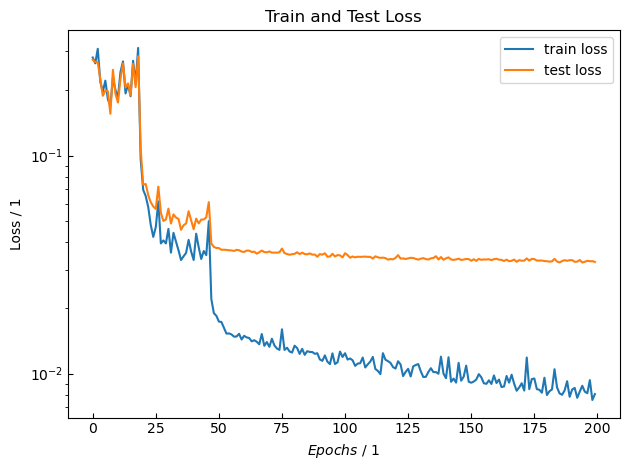

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_017.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998161525125279 , R^2(NH3) = 0.9998121863446977
Test Dataset: R^2(H2) = 0.9987411057372093 , R^2(NH3) = 0.9975075190322213
Max Error Training: |x_H2 - x_H2,pred| = 0.04148141806666461 , |x_NH3 - x_NH3,pred| = 0.007409711799815033
Max Error Test: |x_H2 - x_H2,pred| = 0.022988118063790974 , |x_NH3 - x_NH3,pred| = 0.01734762103353199


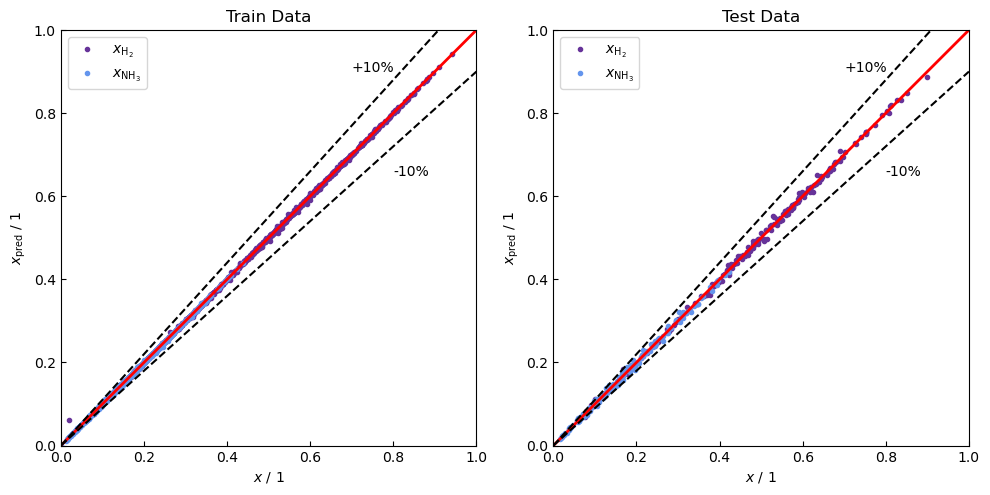

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

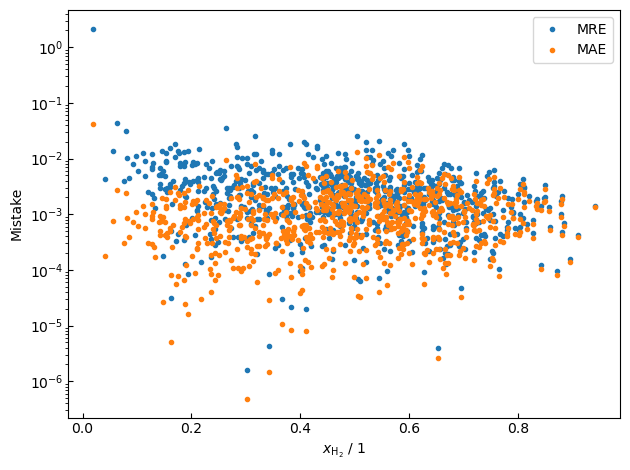

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

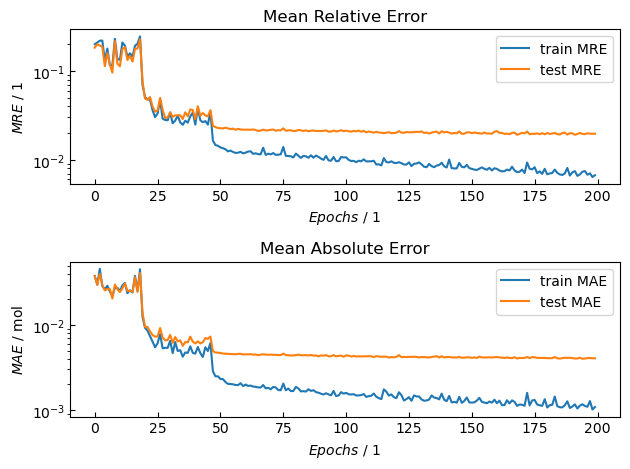

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

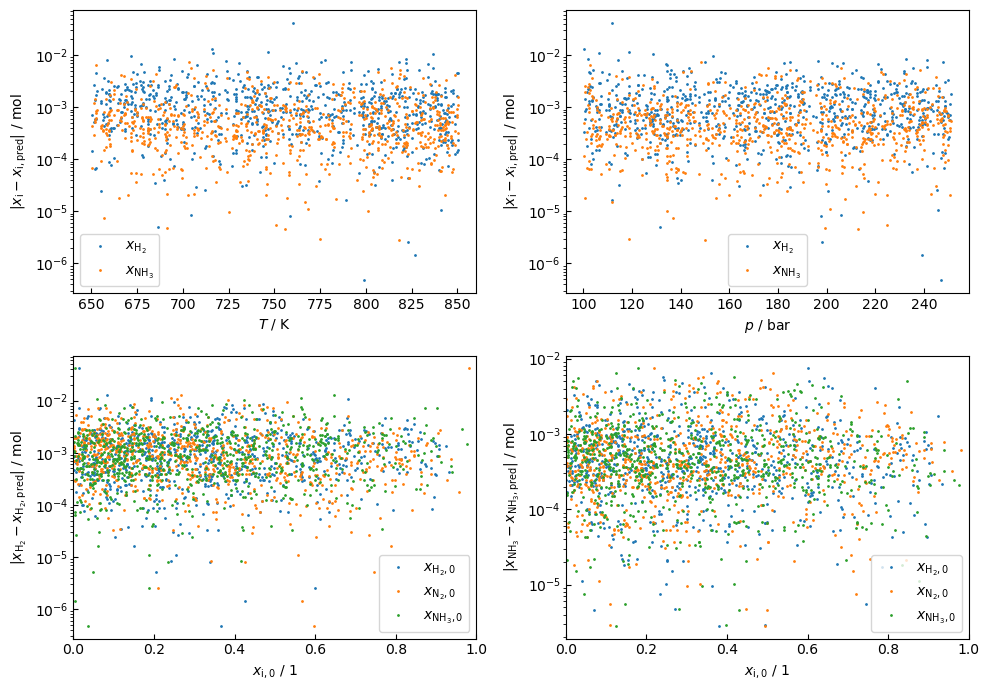

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

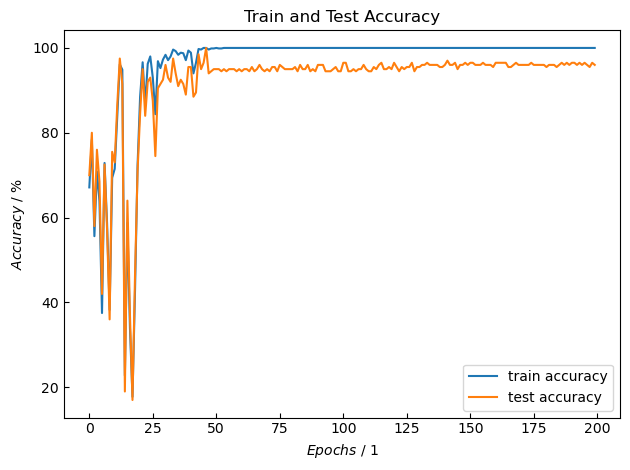

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.8091e-01, -1.4866e+00, -6.5910e-01,  1.1967e+00, -5.7630e-01],
        [ 1.0787e+00,  1.0912e+00,  3.7175e-02, -1.3056e+00,  1.2979e+00],
        [ 5.4274e-01,  9.8198e-02, -1.3514e+00,  2.0746e+00, -7.9419e-01],
        [-7.3060e-01, -1.6883e+00,  7.1324e-01, -1.0389e+00,  3.6188e-01],
        [-5.9056e-01, -1.1820e+00,  5.6155e-01, -7.2274e-02, -4.7722e-01],
        [ 6.1611e-01,  4.7341e-01, -1.4240e-01, -1.0264e+00,  1.1888e+00],
        [-2.9919e-01,  3.1501e-01,  1.2641e+00, -6.0286e-01, -6.2435e-01],
        [ 7.1343e-01, -4.8503e-01,  8.9782e-01,  4.7236e-01, -1.3639e+00],
        [ 1.1900e+00,  7.0348e-01, -2.3455e-02, -1.0976e+00,  1.1448e+00],
        [ 1.3765e+00, -8.7062e-04,  8.6525e-01, -1.3326e+00,  5.1291e-01],
        [ 1.6185e+00,  1.2815e+00,  7.6365e-02,  1.0351e+00, -1.1329e+00],
        [-6.1863e-01, -6.0208e-01, -4.2254e-01,  2.3183e-01,  1.7773e-01],
        [ 3.9241e-01, -1.5774e+00,  1.3533e-01, -6.1199e-01,  4.9269e-01],
        [ 1.4001e+00, -1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.9190e-02, -1.8586e-01, -1.2898e-02, -2.0343e-01,  3.1367e-01],
         [-3.2817e-02,  1.2813e-01,  1.8595e-01, -5.6358e-01, -7.0223e-02],
         [-3.2100e-01, -4.2974e-02, -2.0428e-01, -2.3394e-01,  6.2869e-02],
         [ 6.6088e-01,  3.1806e-02, -3.4961e-01,  3.0089e-01,  4.9688e-02],
         [ 3.3842e-01, -8.7861e-02,  3.3045e-01, -3.8099e-01,  1.1768e-01],
         [-1.1377e-01, -9.5015e-02, -4.5489e-01,  2.2313e-01, -3.5691e-02],
         [ 4.9815e-01, -2.0604e-01,  1.6354e-01, -2.0052e-01, -6.2672e-02],
         [ 3.6684e-01, -1.8218e-01, -2.4963e-01,  4.1407e-01, -7.2303e-02],
         [-3.5537e-01, -1.9039e-02, -4.1418e-01,  2.1894e-01, -2.8805e-01],
         [-1.2831e-01, -1.1637e-01, -1.4043e-01, -2.2831e-01, -1.4760e-01],
         [-5.1554e-01, -4.5240e-03, -6.0259e-02, -2.1132e-01,  1.4832e-01],
         [ 3.9899e-01, -1.1014e-02,  1.9267e-01,  1.0289e-01,  5.4041e-02],
         [-1.0781e-01,  1.1582e-01, -2.9860e-01,  6.2480e-01, -2.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.9969, 0.6229, 0.5956, 0.1822, 0.9245],
        [0.3856, 0.1026, 0.6591, 0.0735, 0.9743]])
tensor([[ 0.5046, -0.3680],
        [ 0.5519, -0.0392]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.3124, -0.4549, -0.6977,  0.7187, -0.0498],
        [-0.8350,  1.5349, -0.6800,  1.7380, -1.1091],
        [-0.6186, -0.6021, -0.4225,  0.2318,  0.1777],
        [-1.4143,  0.0067,  0.1489,  0.7885, -0.9521],
        [ 0.2214,  0.9939, -1.0644,  2.1124, -1.1144],
        [-1.7680,  0.4974,  1.0836, -0.4049, -0.6496],
        [ 1.0918,  0.1352,  0.6263, -0.8885,  0.2935],
        [-1.0688, -0.6831,  1.1443, -1.0284, -0.0719],
        [-1.6187,  1.1109,  0.8888,  0.3848, -1.2655],
        [-0.2293, -0.0639, -0.6230,  0.8021, -0.2084],
        [ 0.2709, -1.6156, -0.8607,  0.2237,  0.6161],
        [-1.4235,  0.5844, -0.2283,  0.4061, -0.1910],
        [ 1.0366, -1.6512, -0.8804, -0.7937,  1.6753],
        [-0.7026, -1.0340, -0.2733, -0.8294,  1.1159],
        [ 0.8806,  0.2243,  0.5642,  0.0815, -0.6370],
        [-1.7006,  0.5709, -0.9870,  1.1048, -0.1606]])
tensor([-8.3267e-17,  4.1633e-17,  5.5511e-17,  0.0000e+00, -2.7756e-17],
       grad_fn=<MeanBackward1>)
tensor([[-0.7

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()